In [7]:
import numpy as np
import pandas as pd
import librosa
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch.nn.functional as F
import simpleaudio as sa



In [22]:

# Load metadata
metadata = pd.read_csv('metadata/development.csv')
labels = metadata['word'].values
file_paths = metadata['filename'].values  # Assuming the CSV has a column with the paths to the wav files
path_prefix = 'data/'  # Change this to the path where the wav files are stored

# Extract features from WAV files
def extract_features(file_paths):
    features = []
    for file in file_paths:
        
        y, sr = librosa.load(file, sr=None)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfccs_scaled = np.mean(mfccs.T, axis=0)  # Taking mean over time axis
        features.append(mfccs_scaled)
    return np.array(features)


In [23]:
# Extract features for all samples
X = extract_features(file_paths)
y = labels

# Train-test split
subsample_fraction = 0.99
X_subsample, _, y_subsample, _, snippet_ids_subsample, _ = train_test_split(
    X, y, np.arange(len(metadata)), train_size=subsample_fraction, random_state=42)

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_subsample, y_subsample, test_size=0.3, random_state=42, stratify=y_subsample)

# SMOTE for balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_val, y_train_val)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)


In [24]:
# Dataset class for PyTorch
class AudioDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Encode labels
unique_labels = np.unique(y_resampled)
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_resampled_mapped = np.array([label_mapping[label] for label in y_resampled])
y_test_mapped = np.array([label_mapping[label] for label in y_test])

# Create PyTorch datasets and loaders
train_dataset = AudioDataset(X_train_scaled, y_resampled_mapped)
test_dataset = AudioDataset(X_test_scaled, y_test_mapped)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [25]:
# Define the CNN model
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (40 // 4), 128)  # Adjusting for pooling
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [33]:
class AudioCNNV2(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNNV2, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(2)
        
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(2)
        
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(2)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * (40 // 8), 256)  # Adjusting for additional pooling
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_classes)
    
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [35]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [38]:
# Instantiate the model, loss function, and optimizer
num_classes = len(unique_labels)
model = AudioCNNV2(num_classes=num_classes)
# model.to(mps_device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
num_epochs = 50
model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")



RuntimeError: Mismatched Tensor types in NNPack convolutionOutput

              precision    recall  f1-score   support

       Alarm       0.61      0.59      0.60       605
    Brötchen       0.44      0.43      0.44       607
   Fernseher       0.61      0.60      0.61       609
        Haus       0.46      0.42      0.44       605
     Heizung       0.42      0.45      0.43       607
     Leitung       0.37      0.39      0.38       609
       Licht       0.58      0.58      0.58       608
     Lüftung       0.49      0.50      0.49       608
        Ofen       0.47      0.45      0.46       608
       Radio       0.44      0.40      0.42       604
    Schraube       0.51      0.57      0.54       608
     Spiegel       0.67      0.78      0.72       604
 Staubsauger       0.60      0.67      0.64       605
          an       0.57      0.50      0.53       607
         aus       0.47      0.48      0.47       607
        kann       0.47      0.48      0.47       608
       nicht       0.57      0.52      0.55       607
       offen       0.38    

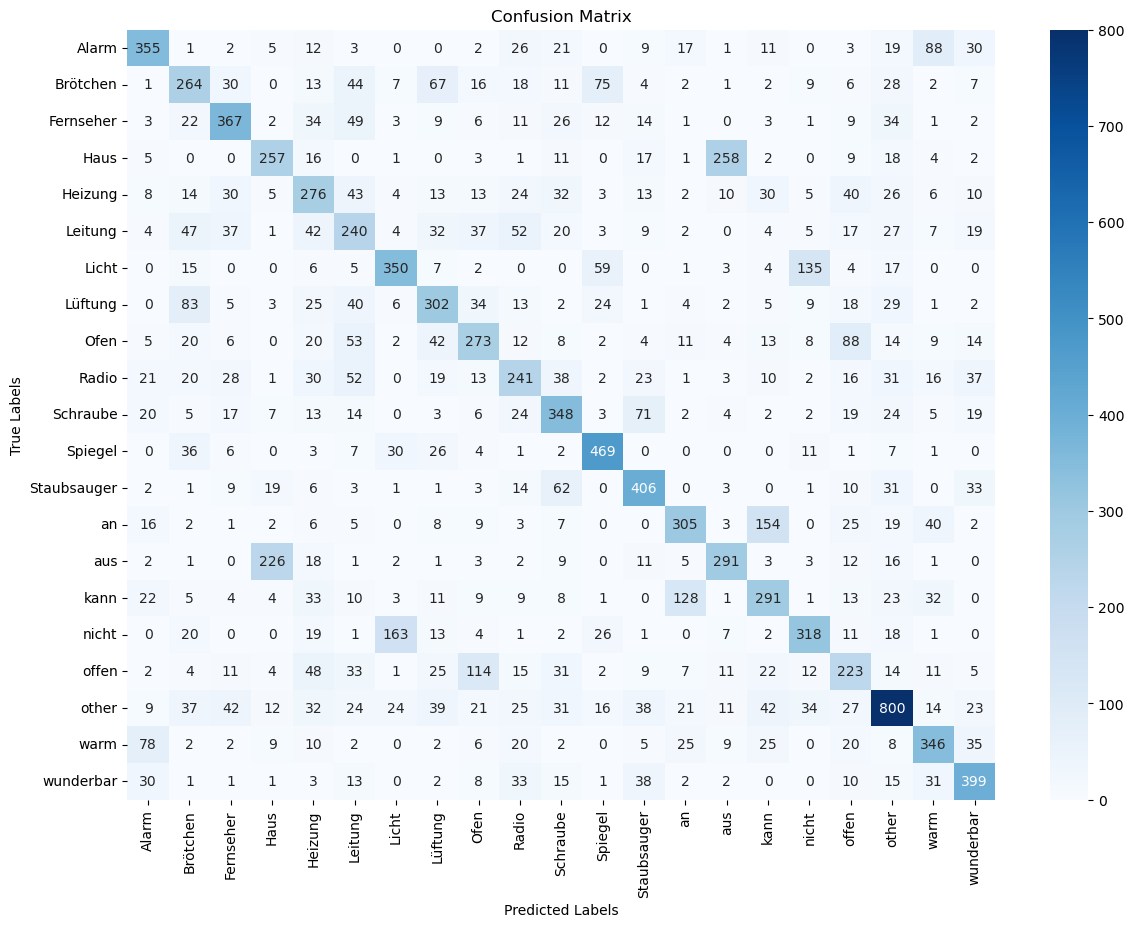

In [ ]:
# Evaluating the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.unsqueeze(1)  # Add channel dimension
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# Generate classification report and confusion matrix
print(classification_report(all_labels, all_preds, target_names=unique_labels))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(14, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [28]:
def play_and_predict(file_path, model, scaler, label_mapping):
    # Load and play the sound
    wave_obj = sa.WaveObject.from_wave_file(file_path)
    play_obj = wave_obj.play()
    play_obj.wait_done()
    
    # Extract features
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs.T, axis=0)
    
    # Scale features
    mfccs_scaled = scaler.transform([mfccs_scaled])
    
    # Predict label
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(mfccs_scaled, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
        output = model(input_tensor)
        _, predicted_label = torch.max(output, 1)
        predicted_word = [word for word, idx in label_mapping.items() if idx == predicted_label.item()][0]
    
    print(f"Predicted word: {predicted_word}")

# Example usage
file_path = 'words/Licht/4.wav'
play_and_predict(file_path, model, scaler, label_mapping)

Predicted word: Licht


In [30]:
import torch

# Save the model's state dictionary
torch.save(model.state_dict(), 'models/audio_cnn_model_fulldataset.pth')

# Optionally, save the entire model (including architecture and weights)
torch.save(model, 'models/audio_cnn_model_complete_fulldataset.pth')

# Save the scaler and label mapping using joblib
import joblib
joblib.dump(scaler, 'models/scaler_fulldataset.pkl')
joblib.dump(label_mapping, 'models/label_mapping_fulldataset.pkl')

['models/label_mapping_fulldataset.pkl']